<a href="https://colab.research.google.com/github/ItalianPepper/COVID19-Italy-Analysis/blob/master/coronavirus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Siate responsabili per voi stessi e i vostri cari ed osservate le normative del Governo Italiano.

I grafici mostrano esclusivamente i dati della Protezione Civile.

Le previsioni considerano l'andamento del virus nel numero di giorni precedenti definiti dalla variabile 'look_back'.

Le previsioni sono soggette ad oscillazioni.

MAE (Mean Absolute Error) https://it.wikipedia.org/wiki/Errore_quadratico_medio

MSE (Mean Square Error) https://it.wikipedia.org/wiki/Scarto_medio_assoluto

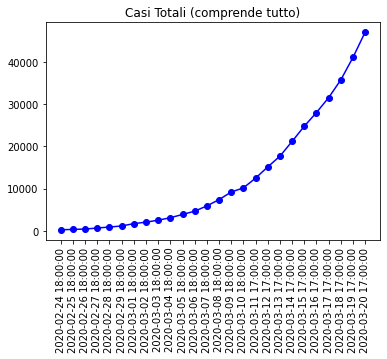

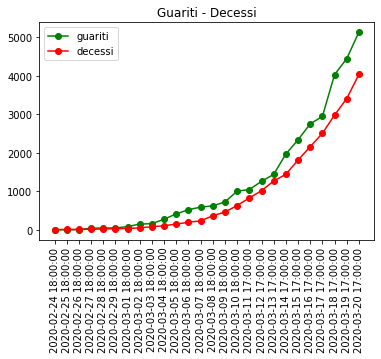

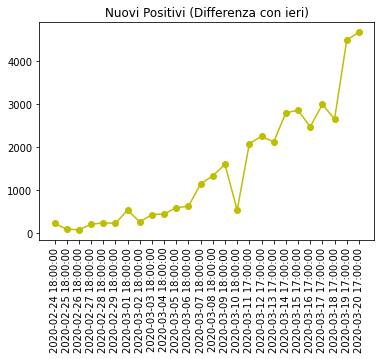

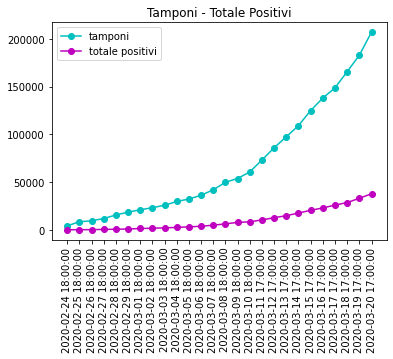

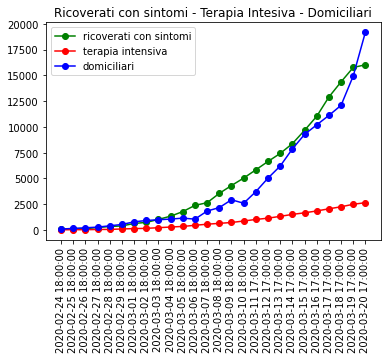

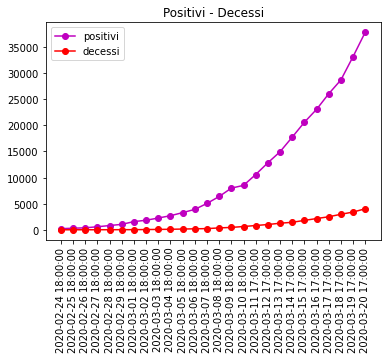

Ultimo aggiornamento del 2020-03-20 17:00:00
Numero di casi:  47021
Guariti:  5129
Decessi:  4032
---
Rapporto positivi/tamponi in percentuale (ultime osservazioni): 100.0
---
Tasso di letalità (decessi/positivi_totali) in percentuale): 10.649762282091919
---
Previsioni - Regressione Polinomiale
Casi Totali
Test MAE: 459.320
Test MSE: 265448.767
2020-03-21 18:00:00 : 52653
---
Guariti
Test MAE: 523.122
Test MSE: 276752.256
2020-03-21 18:00:00 : 5155
---
Decessi
Test MAE: 48.054
Test MSE: 3842.475
2020-03-21 18:00:00 : 4499
---


In [2]:
import urllib
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import datetime

# Download .csv file from official profile of Protezione Civile.
raw_git_url = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv"
csv_name = "dpc-covid19-ita-andamento-nazionale.csv"
urllib.request.urlretrieve(raw_git_url, csv_name)


df_ita_covid = pd.read_csv(csv_name, sep=",", header=0)
tot_casi_col = df_ita_covid["totale_casi"].tolist()
tot_healed_col = df_ita_covid["dimessi_guariti"].tolist()
tot_deaths_col = df_ita_covid["deceduti"].tolist()
dates_col = df_ita_covid["data"].tolist()
new_positive_col = df_ita_covid["nuovi_attualmente_positivi"].tolist()
tot_actual_positive_col = df_ita_covid["totale_attualmente_positivi"].tolist()
tot_swabs_col = df_ita_covid["tamponi"].tolist()

tot_recovery = df_ita_covid["ricoverati_con_sintomi"].tolist()
tot_dom = df_ita_covid["isolamento_domiciliare"].tolist()
intensitive_care = df_ita_covid["terapia_intensiva"].tolist()


# Total cases
plt.plot_date(dates_col, tot_casi_col, 'ob-', xdate=True, )
plt.title("Casi Totali (comprende tutto)")
plt.xticks(rotation=90)
plt.show()
plt.close()

# Healed - Deaths
plt.plot_date(dates_col, tot_healed_col, 'og-', xdate=True)
plt.plot_date(dates_col, tot_deaths_col, 'or-', xdate=True)
plt.title("Guariti - Decessi")
plt.legend(["guariti", "decessi"])
plt.xticks(rotation=90)
plt.show()
plt.close()


# New Positives
plt.plot_date(dates_col, new_positive_col, 'oy-', xdate=True)
plt.title("Nuovi Positivi (Differenza con ieri)")
plt.xticks(rotation=90)
plt.show()
plt.close()

# Swabs - Tot positives
plt.plot_date(dates_col, tot_swabs_col, 'oc-', xdate=True)
plt.plot_date(dates_col, tot_actual_positive_col, 'om-', xdate=True)
plt.title("Tamponi - Totale Positivi")
plt.legend(["tamponi", "totale positivi"])
plt.xticks(rotation=90)
plt.show()
plt.close()


# Tot Hospitalized - Intensitive Care - Home Isolation - Actual Positives
plt.plot_date(dates_col, tot_recovery, 'og-', xdate=True)
plt.plot_date(dates_col, intensitive_care, 'or-', xdate=True)
plt.plot_date(dates_col, tot_dom, 'ob-', xdate=True)
plt.title("Ricoverati con sintomi - Terapia Intesiva - Domiciliari")
plt.legend(["ricoverati con sintomi", "terapia intensiva", "domiciliari"])
plt.xticks(rotation=90)
plt.show()
plt.close()

#Tot Positives - Decessi
plt.plot_date(dates_col, tot_actual_positive_col, 'om-', xdate=True)
plt.plot_date(dates_col, tot_deaths_col, 'or-', xdate=True)
plt.title("Positivi - Decessi")
plt.legend(["positivi", "decessi"])
plt.xticks(rotation=90)
plt.show()
plt.close()

def run_model(dates, col_selected, look_forward=1):
  x = []
  y = []

  for i in range(0, len(col_selected)): 
    
    x.append([i])
    y.append(col_selected[i])

  x = np.array(x).reshape(len(x), 1)
  y = np.array(y).reshape(len(y))

  date_format = "%Y-%m-%d %H:%M:%S"
  
  # Future elements for forecast
  futures_dates = []
  start_date = dates[0]
  start_date = datetime.datetime.strptime(start_date, date_format)
  
  futures_x = [i for i in range(len(col_selected), len(col_selected)+look_forward)]
  futures_x = np.array(futures_x).reshape(len(futures_x), 1)

  for i in range(len(col_selected), (len(col_selected) + look_forward)):
    futures_dates.append((start_date + datetime.timedelta(days=i)).strftime(date_format))
  
  poly_features = PolynomialFeatures(degree=3, include_bias=False)
  x_poly = poly_features.fit_transform(x)

  x_train, x_test, y_train, y_test = train_test_split(x_poly, y,
                                                        test_size=0.1,
                                                        shuffle=False)
  model = LinearRegression()
  model.fit(x_train, y_train)

  pred = model.predict(x_test)

  error_abs = mean_absolute_error(y_test, pred)
  error_mse = mean_squared_error(y_test, pred)

  print('Test MAE: %.3f' % error_abs)
  print('Test MSE: %.3f' % error_mse)

  poly_futures_x = poly_features.fit_transform(futures_x)
  forecast = model.predict(poly_futures_x)
  for i in range(0, len(forecast)):
    print(futures_dates[i], ":", int(forecast[i]))
  print("---")


last_date = dates_col[len(dates_col)-1]

print("Ultimo aggiornamento del", last_date)
print("Numero di casi: ", tot_casi_col[len(tot_casi_col)-1]);
print("Guariti: ", tot_healed_col[len(tot_healed_col)-1]);
print("Decessi: ", tot_deaths_col[len(tot_deaths_col)-1]);
print("---")


last_obs_deaths = tot_deaths_col[len(tot_deaths_col)-1]
last_obs_positives = tot_actual_positive_col[len(tot_actual_positive_col)-1]

letality_percent = (last_obs_deaths/last_obs_positives)*100


last_obs_swabs = tot_swabs_col[len(tot_swabs_col)-1]
pos_swabs_ratio = (last_obs_positives/last_obs_positives)*100
print("Rapporto positivi/tamponi in percentuale (ultime osservazioni):",
      pos_swabs_ratio)
print("---")

print("Tasso di letalità (decessi/positivi_totali) in percentuale):", 
      letality_percent)
print("---")

print("Previsioni - Regressione Polinomiale")

print("Casi Totali")
run_model(dates_col, tot_casi_col, look_forward=1)

print("Guariti")
run_model(dates_col, tot_healed_col, look_forward=1)

print("Decessi")
run_model(dates_col, tot_deaths_col, look_forward=1)
